In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from river import evaluate
from river import metrics
from AdaptiveALMA import AdaptiveALMA

from river import stream, compose
from river import preprocessing
from river import linear_model as ln
from river import multiclass

%matplotlib inline

In [2]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/CIC/CIC_Spoofing_Attack.csv")
print('Number of samples  %s' % Counter(df['label']))
X1 = df.drop(['label'], axis=1)
y1 = df['label']
X1, y1 = shuffle(X1, y1, random_state=42)

Number of samples  Counter({0: 10525, 1: 4788})


In [3]:
data=pd.read_csv("/Users/promisea/ALMA/CIC/CIC_Mirai_Attack.csv")
print('Number of samples  %s' % Counter(df['label']))
X2 = data.drop(['label'], axis=1)
y2 = data['label']
X2, y2 = shuffle(X2, y2, random_state=42)

Number of samples  Counter({0: 10525, 1: 4788})


In [4]:
spoof = stream.iter_pandas(X1, y1)
mirai = stream.iter_pandas(X2, y2)

In [5]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier()
)

In [6]:
from river.metrics import Accuracy
import matplotlib.pyplot as plt
from collections import defaultdict

def process1(dataset1, dataset2, window_size=100):
    performances = defaultdict(list)
    temp_performances = defaultdict(list)
    indices = []

    # Create new instances of the metric for each class
    metrics = {0: Accuracy(), 1: Accuracy()}  

    # Process the first dataset
    for i, (xi, yi) in enumerate(dataset1):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())
        
        # Calculate window average every window_size samples
        if (i + 1) % window_size == 0:
            for key in metrics:
                if temp_performances[key]:  # Check if there are elements
                    average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                    performances[key].append(average_accuracy)
                    temp_performances[key].clear()  # Reset the temporary list
            indices.append(i)

    # Print accuracies after processing the first dataset
    print("Accuracies after processing Spoofing:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    end_of_dataset1 = len(indices) * window_size - 1  # Mark the end of the first dataset

    # Process the second dataset
    i_offset = i + 1  # Starting index for the second dataset
    for j, (xi, yi) in enumerate(dataset2, start=i_offset):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())

        # Calculate window average every window_size samples
        if (j + 1 - i_offset) % window_size == 0:
            for key in metrics:
                if temp_performances[key]:  # Check if there are elements
                    average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                    performances[key].append(average_accuracy)
                    temp_performances[key].clear()  # Reset the temporary list
            indices.append(j)

    # Print accuracies after processing the datasets
    print("Accuracies after processing Mirai:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    # Plotting the accuracies for both classes in a single figure
    plt.figure(figsize=(10, 6))
    for key in performances:
        plt.plot(indices[:len(performances[key])], performances[key], label=f"Class {key} Accuracy")
    plt.axvline(x=end_of_dataset1, color='red', linestyle='--', label='End of Spoofing')
    plt.xlabel('Number of Samples', fontweight='bold')
    plt.ylabel('Accuracy', fontweight='bold')
    plt.title('Continuous Model Performance of Benign, Spoofing and Mirai of the CIC 2023 Dataset using ALMA', fontweight='bold')
    
    # Set the tick labels to be bold
    ax = plt.gca()  # Get the current Axes instance
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        
    plt.legend()
    plt.savefig('ALMA_CIC_Classes_1.png')
    plt.show()

    return indices, dict(performances)

Accuracies after processing Spoofing:
Class 0: 0.6699287410926366
Class 1: 0.6071428571428571
Accuracies after processing Mirai:
Class 0: 0.8135866983372921
Class 1: 0.9302131076243685


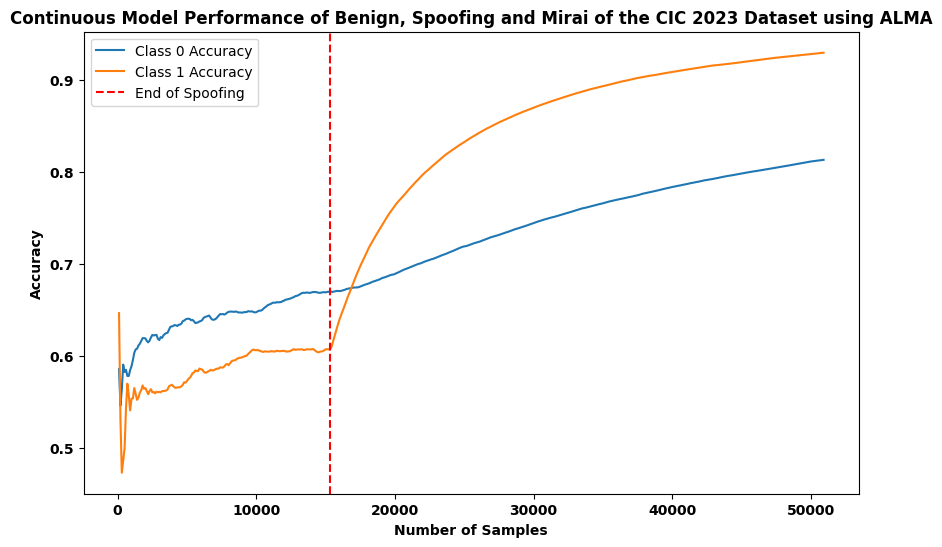

In [7]:
# Process the first dataset
indices, performances = process1(spoof, mirai)

In [8]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier()
)

In [9]:
spoof = stream.iter_pandas(X1, y1)
mirai = stream.iter_pandas(X2, y2)

In [10]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

In [11]:
from river.metrics import Accuracy
import matplotlib.pyplot as plt
from collections import defaultdict

def process1(dataset1, dataset2, window_size=100):
    performances = defaultdict(list)
    temp_performances = defaultdict(list)
    indices = []

    # Create new instances of the metric for each class
    metrics = {0: Accuracy(), 1: Accuracy()}  

    # Process the first dataset
    for i, (xi, yi) in enumerate(dataset1):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())
        
        # Calculate window average every window_size samples
        if (i + 1) % window_size == 0:
            for key in metrics:
                if temp_performances[key]:  # Check if there are elements
                    average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                    performances[key].append(average_accuracy)
                    temp_performances[key].clear()  # Reset the temporary list
            indices.append(i)

    # Print accuracies after processing the first dataset
    print("Accuracies after processing Spoofing:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    end_of_dataset1 = len(indices) * window_size - 1  # Mark the end of the first dataset

    # Process the second dataset
    i_offset = i + 1  # Starting index for the second dataset
    for j, (xi, yi) in enumerate(dataset2, start=i_offset):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())

        # Calculate window average every window_size samples
        if (j + 1 - i_offset) % window_size == 0:
            for key in metrics:
                if temp_performances[key]:  # Check if there are elements
                    average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                    performances[key].append(average_accuracy)
                    temp_performances[key].clear()  # Reset the temporary list
            indices.append(j)

    # Print accuracies after processing the datasets
    print("Accuracies after processing Mirai:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    # Plotting the accuracies for both classes in a single figure
    plt.figure(figsize=(10, 6))
    for key in performances:
        plt.plot(indices[:len(performances[key])], performances[key], label=f"Class {key} Accuracy")
    plt.axvline(x=end_of_dataset1, color='red', linestyle='--', label='End of Spoofing')
    plt.xlabel('Number of Samples', fontweight='bold')
    plt.ylabel('Accuracy', fontweight='bold')
    plt.title('Continuous Model Performance of Benign, Spoofing and Mirai of the CIC 2023 Dataset using Adaptive ALMA', fontweight='bold')
    
    # Set the tick labels to be bold
    ax = plt.gca()  # Get the current Axes instance
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        
    plt.legend()
    plt.savefig('Adaptive_ALMA_CIC_Classes_1.png')
    plt.show()

    return indices, dict(performances)

Accuracies after processing Spoofing:
Class 0: 0.716769596199525
Class 1: 0.6303258145363408
Accuracies after processing Mirai:
Class 0: 0.7314964370546319
Class 1: 0.5965675286875648


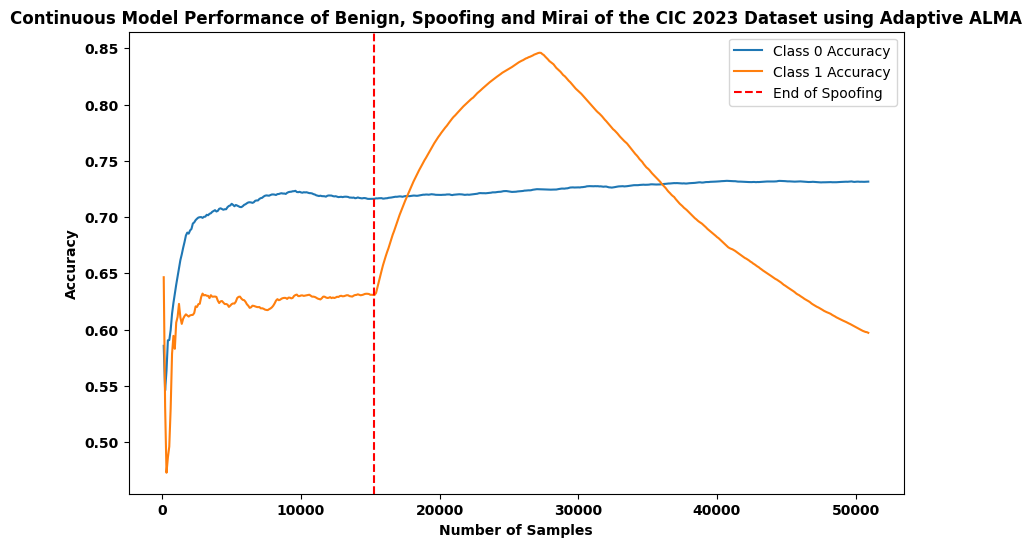

In [12]:
# Process the first dataset
indices, performances = process1(spoof, mirai)

In [13]:
spoof = stream.iter_pandas(X1, y1)
mirai = stream.iter_pandas(X2, y2)

In [14]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier()
)

In [15]:
from river.metrics import Accuracy
import matplotlib.pyplot as plt
from collections import defaultdict

def process2(dataset1, dataset2, window_size=100):
    performances = defaultdict(list)
    temp_performances = defaultdict(list)
    indices = []

    # Create new instances of the metric for each class
    metrics = {0: Accuracy(), 1: Accuracy()}  

    # Process the first dataset
    for i, (xi, yi) in enumerate(dataset1):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())
        
        # Calculate window average every window_size samples
        if (i + 1) % window_size == 0:
            for key in metrics:
                if temp_performances[key]:  # Check if there are elements
                    average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                    performances[key].append(average_accuracy)
                    temp_performances[key].clear()  # Reset the temporary list
            indices.append(i)

    # Print accuracies after processing the first dataset
    print("Accuracies after processing Mirai:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    end_of_dataset1 = len(indices) * window_size - 1  # Mark the end of the first dataset

    # Process the second dataset
    i_offset = i + 1  # Starting index for the second dataset
    for j, (xi, yi) in enumerate(dataset2, start=i_offset):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())

        # Calculate window average every window_size samples
        if (j + 1 - i_offset) % window_size == 0:
            for key in metrics:
                if temp_performances[key]:  # Check if there are elements
                    average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                    performances[key].append(average_accuracy)
                    temp_performances[key].clear()  # Reset the temporary list
            indices.append(j)

    # Print accuracies after processing the datasets
    print("Accuracies after processing Spoofing:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    # Plotting the accuracies for both classes in a single figure
    plt.figure(figsize=(10, 6))
    for key in performances:
        plt.plot(indices[:len(performances[key])], performances[key], label=f"Class {key} Accuracy")
    plt.axvline(x=end_of_dataset1, color='red', linestyle='--', label='End of Mirai')
    plt.xlabel('Number of Samples', fontweight='bold')
    plt.ylabel('Accuracy', fontweight='bold')
    plt.title('Continuous Model Performance of Benign, Mirai and Spoofing of the CIC 2023 Dataset using ALMA', fontweight='bold')
    
    # Set the tick labels to be bold
    ax = plt.gca()  # Get the current Axes instance
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        
    plt.legend()
    plt.savefig('ALMA_CIC_Classes_2.png')
    plt.show()

    return indices, dict(performances)

Accuracies after processing Mirai:
Class 0: 0.9556294536817103
Class 1: 0.9872923554953591
Accuracies after processing Spoofing:
Class 0: 0.8650356294536817
Class 1: 0.9082667023518785


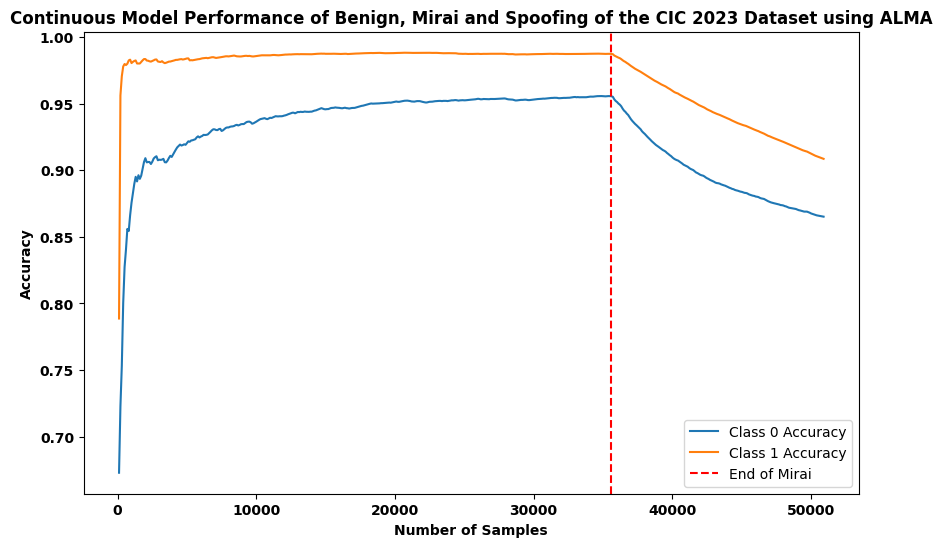

In [16]:
# Process the first dataset
indices, performances = process2(mirai, spoof)

In [17]:
spoof = stream.iter_pandas(X1, y1)
mirai = stream.iter_pandas(X2, y2)

In [18]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

In [19]:
from river.metrics import Accuracy
import matplotlib.pyplot as plt
from collections import defaultdict

def process2(dataset1, dataset2, window_size=100):
    performances = defaultdict(list)
    temp_performances = defaultdict(list)
    indices = []

    # Create new instances of the metric for each class
    metrics = {0: Accuracy(), 1: Accuracy()}  

    # Process the first dataset
    for i, (xi, yi) in enumerate(dataset1):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())
        
        # Calculate window average every window_size samples
        if (i + 1) % window_size == 0:
            for key in metrics:
                if temp_performances[key]:  # Check if there are elements
                    average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                    performances[key].append(average_accuracy)
                    temp_performances[key].clear()  # Reset the temporary list
            indices.append(i)

    # Print accuracies after processing the first dataset
    print("Accuracies after processing Mirai:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    end_of_dataset1 = len(indices) * window_size - 1  # Mark the end of the first dataset

    # Process the second dataset
    i_offset = i + 1  # Starting index for the second dataset
    for j, (xi, yi) in enumerate(dataset2, start=i_offset):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())

        # Calculate window average every window_size samples
        if (j + 1 - i_offset) % window_size == 0:
            for key in metrics:
                if temp_performances[key]:  # Check if there are elements
                    average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                    performances[key].append(average_accuracy)
                    temp_performances[key].clear()  # Reset the temporary list
            indices.append(j)

    # Print accuracies after processing the datasets
    print("Accuracies after processing Spoofing:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    # Plotting the accuracies for both classes in a single figure
    plt.figure(figsize=(10, 6))
    for key in performances:
        plt.plot(indices[:len(performances[key])], performances[key], label=f"Class {key} Accuracy")
    plt.axvline(x=end_of_dataset1, color='red', linestyle='--', label='End of Mirai')
    plt.xlabel('Number of Samples', fontweight='bold')
    plt.ylabel('Accuracy', fontweight='bold')
    plt.title('Continuous Model Performance of Benign, Mirai and Spoofing of the CIC 2023 Dataset using Adaptive ALMA', fontweight='bold')
    
    # Set the tick labels to be bold
    ax = plt.gca()  # Get the current Axes instance
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        
    plt.legend()
    plt.savefig('Adaptive_ALMA_CIC_Classes_2.png')
    plt.show()

    return indices, dict(performances)

Accuracies after processing Mirai:
Class 0: 0.9705463182897862
Class 1: 0.989323985181054
Accuracies after processing Spoofing:
Class 0: 0.9154869358669834
Class 1: 0.9095714429092369


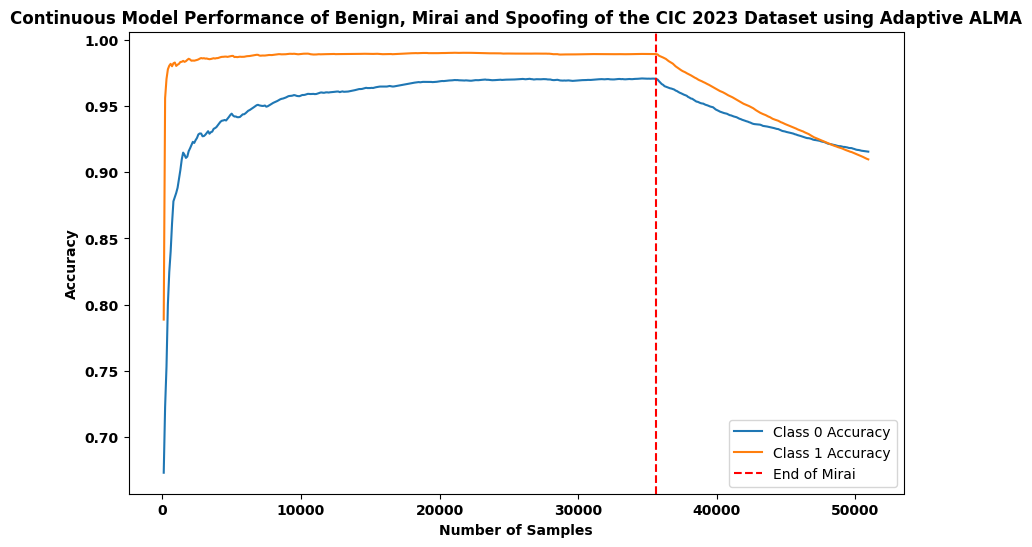

In [20]:
# Process the first dataset
indices, performances = process2(mirai, spoof)

In [21]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/CIC/CIC_Spoofing_Attack.csv")
print('Number of samples  %s' % Counter(df['label']))
X1 = df.drop(['label'], axis=1)
y1 = df['label']
X1, y1 = shuffle(X1, y1, random_state=42)
dataset = stream.iter_pandas(X1, y1)

Number of samples  Counter({0: 10525, 1: 4788})


In [22]:
ALMA = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier()
)
#Passing the evalaution metrics into a variable
report = metrics.F1()

In [23]:
%%time

evaluate.progressive_val_score(dataset, ALMA, report, print_every=10000)

[10,000] F1: 51.42%
[15,313] F1: 52.05%
CPU times: user 2 s, sys: 20.6 ms, total: 2.02 s
Wall time: 1.96 s


F1: 52.05%

In [24]:
dataset = stream.iter_pandas(X1, y1)

In [25]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)
#Passing the evalaution metrics into a variable
report = metrics.F1()

In [26]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=10000)

[10,000] F1: 56.64%
[15,313] F1: 55.96%
CPU times: user 2.03 s, sys: 17.8 ms, total: 2.05 s
Wall time: 2.1 s


F1: 55.96%

In [27]:
data=pd.read_csv("/Users/promisea/ALMA/CIC/CIC_Mirai_Attack.csv")
print('Number of samples  %s' % Counter(df['label']))
X2 = data.drop(['label'], axis=1)
y2 = data['label']
X2, y2 = shuffle(X2, y2, random_state=42)
dataset = stream.iter_pandas(X2, y2)

Number of samples  Counter({0: 10525, 1: 4788})


In [28]:
ALMA = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier()
)
#Passing the evalaution metrics into a variable
report = metrics.F1()

In [29]:
%%time

evaluate.progressive_val_score(dataset, ALMA, report, print_every=10000)

[10,000] F1: 97.95%
[20,000] F1: 98.38%
[30,000] F1: 98.37%
[35,628] F1: 98.44%
CPU times: user 4.34 s, sys: 21 ms, total: 4.36 s
Wall time: 4.54 s


F1: 98.44%

In [30]:
dataset = stream.iter_pandas(X2, y2)

In [31]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)
#Passing the evalaution metrics into a variable
report = metrics.F1()

In [32]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=10000)

[10,000] F1: 98.59%
[20,000] F1: 98.84%
[30,000] F1: 98.82%
[35,628] F1: 98.85%
CPU times: user 4.72 s, sys: 17.3 ms, total: 4.74 s
Wall time: 4.92 s


F1: 98.85%